<a href="https://colab.research.google.com/github/El-47/fgc/blob/master/Freshness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import re
from datetime import datetime
import requests
import io
import json
from google.colab.patches import cv2_imshow

In [2]:
def check_freshness(expiry_date):
    """ Check if the item is fresh based on the expiry date. """
    if expiry_date:
        expiry_date_dt = datetime.strptime(expiry_date, '%Y-%m-%d').date()
        current_date = datetime.now().date()
        print(expiry_date)
        print(current_date)
        if current_date > expiry_date_dt:
            return "Not Fresh", 0  # Not fresh
        else:
            return "Fresh",1  # Round to two decimal places
    return "unknown", -1  # Unknown freshness status


In [3]:
def check_freshness2(roi):
    """ Check the freshness of the item based on the ROI color. """
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    avg_color = np.mean(hsv_roi, axis=(0, 1))  # Average over both axes
    avg_hue = avg_color[0]  # Hue channel (0 to 180 in OpenCV)

    freshness_index = 0
    # Define freshness criteria based on Hue and Saturation values
    if 15 < avg_hue < 75:  # Example range for freshness
        freshness_status = "Fresh"
        freshness_index = 1  # Scale based on hue and saturation
    else:
        freshness_status = "Not Fresh"
        freshness_index = 0  # Indicate unknown freshness with None

    return freshness_status, freshness_index


In [4]:
def parse_details(text):
    """ Parse quality and expiry date from text. """
    expiry_dates = []
    quality = None

    # Example patterns (adjust based on label format)
    quality_pattern = re.compile(r'Quality\s*[:\-]\s*(\w+)', re.IGNORECASE)
    expiry_pattern = re.compile(r'Exp\.? Date\s*[:\-]\s*([\d/.-]+\s+\w+\s+\d{4})|(\d{1,2}\s+\w+\s+\d{4})', re.IGNORECASE)

    quality_match = quality_pattern.search(text)
    expiry_matches = expiry_pattern.findall(text)  # Find all expiry date matches

    if quality_match:
        quality = quality_match.group(1).strip()

    # Add found expiry dates to the list
    for match in expiry_matches:
        date_str = match[0] if match[0] else match[1]  # Get the matched date string
        try:
            # Try different date formats
            parsed_date = datetime.strptime(date_str.strip(), '%d %b %Y')  # e.g., "4 MAR 2030"
            expiry_dates.append(parsed_date)
        except ValueError:
            try:
                parsed_date = datetime.strptime(date_str.strip(), '%d/%m/%Y')  # e.g., "04/05/2030"
                expiry_dates.append(parsed_date)
            except ValueError:
                pass  # Handle invalid date formats as needed

    # Determine the latest expiry date
    expiry_date = max(expiry_dates) if expiry_dates else None

    # Convert the expiry date to standard format if it exists
    if expiry_date:
        expiry_date = expiry_date.strftime('%Y-%m-%d')

    return {
        'quality': quality,
        'expiry_date': expiry_date
    }


In [5]:
def ocr_image(roi):
    """ Perform OCR to extract text from the image. """
    url_api = "https://api.ocr.space/parse/image"
    _, compressedimage = cv2.imencode(".jpeg", roi, [1, 90])
    file_bytes = io.BytesIO(compressedimage)

    result = requests.post(url_api, files={"img.jpeg": file_bytes}, data={"apikey": "K87586902988957"})
    result = result.content.decode()
    result = json.loads(result)
    parsed_results = result.get("ParsedResults")[0]
    return parsed_results.get("ParsedText", "")


Saving rottenapple.jpg to rottenapple.jpg
Freshness Status: Not Fresh
Freshness Index: 0


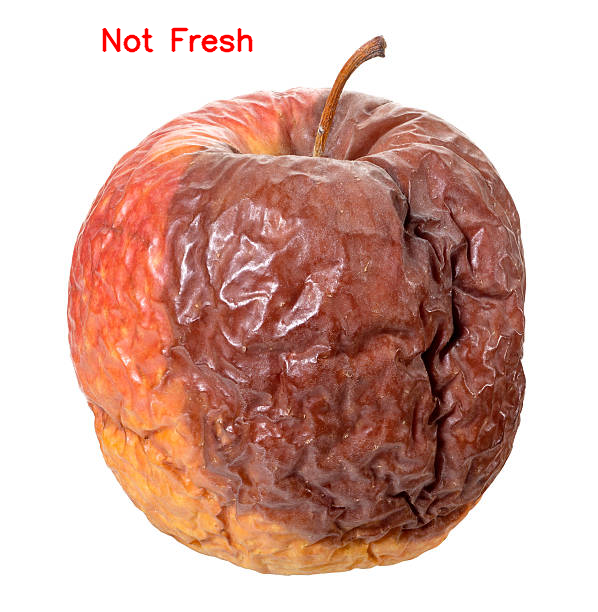

In [6]:
from google.colab import files
import cv2
import numpy as np
from PIL import Image
import io

def main():
    # Upload an image from the user
    uploaded = files.upload()

    # Get the uploaded image file name
    image_name = next(iter(uploaded))

    # Read the uploaded image using OpenCV
    img = cv2.imdecode(np.frombuffer(uploaded[image_name], np.uint8), cv2.IMREAD_COLOR)

    # Get image dimensions
    height, width, _ = img.shape

    # Define ROI (Region of Interest)
    roi = img[0: height, 100: width]  # Adjust this ROI based on your needs

    # Perform OCR to extract label text (You need to define ocr_image and parse_details functions)
    text_detected = ocr_image(roi)

    # Parse the details from the detected text
    details = parse_details(text_detected)

    # Check freshness based on expiry date
    freshness_status, freshness_index = check_freshness(details['expiry_date'])

    if freshness_status != "Fresh":
        freshness_status2, freshness_index2 = check_freshness2(roi)
        print(f"Freshness Status: {freshness_status2}")
        print(f"Freshness Index: {freshness_index2}")

        # Font settings
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color_not_fresh = (0, 0, 255)  # Red for not fresh
        thickness = 2
        line_type = cv2.LINE_AA

        # Overlay freshness status on the original image
        cv2.putText(img, f'{freshness_status2}', (100, 50), font, font_scale, color_not_fresh, thickness, line_type)

    else:
        print(f"Freshness Status: {freshness_status}")
        print(f"Freshness Index: {freshness_index}")

        # Font settings
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color_fresh = (0, 255, 0)  # Green for fresh
        thickness = 2
        line_type = cv2.LINE_AA

        # Overlay freshness status on the original image
        cv2.putText(img, f'{freshness_status}', (100, 50), font, font_scale, color_fresh, thickness, line_type)

    # Display the result
    # cv2_imshow(roi)  # For displaying ROI
    cv2_imshow(img)  # For displaying the full image with the overlay
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
